This Jupyter notebook shows the main contribution of the GenTL paper, which is the heat map. We compare the general source model (GenTL) with single-source models (the conventional approach) for fine-tuning. To demonstrate this, we pretrain individual LSTM models for *number_sources* source buildings. Each model captures the thermal dynamics of its respective building. The general source model was pretrained in a different file (i.e., pretrain_model.ipynb) and is loaded here for comparison.  
Next, we fine-tune *number_targets* target buildings on all single-source models individually and the general source model. The code is shown below. For further explanation, we refer to the paper.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import copy
import os
import seaborn as sns

We define the number of sources and targets for the single-source to single-target training. The sources and targets are sampled from the data folder. We already performed a hyperparameter tuning with the results saved in a yml file. 

In [2]:
from src.utils import sample_from_directory

source_data_path = os.path.join("data", "sources")
target_data_path = os.path.join("data", "targets")

number_sources = 10                  # max 10
number_targets = 8                  # max 8
random_select = True                # sample sources and targets randomly or not from source_data_path or target_data_path

single_source_hyperparameter_path = os.path.join("hyperparameter", "single_source_hyperparameter.json")

try:
    with open(single_source_hyperparameter_path, "r") as hyperparam_file:
        best_hyperparameter_dict = json.load(hyperparam_file)
        print('Hyperparameters found and loaded.')
except OSError:
    best_hyperparameter_dict = {}
    print('No file for hyperparameters. Default config will be used for all runs.')

## 1: sample sources and targets randomly.
selected_training_csvs = sample_from_directory(source_data_path, number_sources, random_select)
selected_ft_csvs = sample_from_directory(target_data_path, number_targets, random_select)
selected_training_csvs.sort()
selected_ft_csvs.sort()

Hyperparameters found and loaded.


Import functionalities from the source code.

In [3]:
from src.preprocessing.preprocessing import *
from src.train import train_model
from src.finetune import finetune_model
from src.utils import get_file_name, load_gentl_model, load_config_file

We need to load the pretrained GenTL model and its configuration to fine-tune it further down.

In [4]:
gentl_config_path = os.path.join("models", "configs", "gentl_config.json")

config_gentl = load_config_file(gentl_config_path)

Also, we define config parameters for fine-tuning of the single sources and the general model. In the paper we used a specific fine-tuning evaluation metric that assesses four different periods of the year for fine-tuning. This resulted in four different models. For computational reasons here we only assess one period of the year, which can be specified by *finetune_split*. In case you want to receive the results of the paper you need to execute this code four times, with the corresponding split of the season.

In [5]:
single_source_config_path = os.path.join("models", "configs", "single_source_config.json")

single_source_config = load_config_file(single_source_config_path)

# Specify the number of epochs to train each single source on.
single_source_config["epochs"] = 50

finetuning_config = {
    "finetune_split": [90, 120],       # Specifies target data's range of days to be finetuned on. The rest of the year will be the validation set.
    "override_optimizer_lr": 0.0001,   # The learning rate can be specified for fine-tuning
    "epochs": 25,
    "batch_size": 32,
    "save_best_val": True
}

Finally, we perform single-source to single-target training.
This means:

First: Train single-source models for every source building we sampled earlier.

Second: Fine-tune each single source model on each target to obtain the final results.

Third: Fine-tune GenTL on each target

In [6]:
config_source_training = single_source_config

device = "cuda"

error_finetuning = {}

# Single source to single target process
for n, source in enumerate(selected_training_csvs):
    file_name = '_' + get_file_name(path=source) + '.csv'
    hyperparams = best_hyperparameter_dict.get(file_name, {})

    print(f"Training single source model on source {source}")

    # Update config based on the best hyperparameter for certain sources.
    config_ = config_source_training.copy()
    config_.update(hyperparams)
    config_["data_path"] = source

    # Train the source model
    result_dict_source, _, scalers_source, best_val_errors_source = train_model(config_, device)

    error_finetuning[source] = {}

    # Finetune on all target CSVs
    for m, target in enumerate(selected_ft_csvs):

        config_ft = config_.copy()
        config_ft["data_path"] = target
        config_ft.update(finetuning_config)

        model_to_ft = copy.deepcopy(result_dict_source["model"])
        optimizer_for_ft = config_ft["optimizer"](model_to_ft.parameters(), lr=config_ft["override_optimizer_lr"])  
        optimizer_for_ft.load_state_dict(result_dict_source["optimizer"].state_dict())      # Has to be this way such that the optimizer knows which parameters to optimize.
        grad_scaler_for_ft = copy.deepcopy(result_dict_source["grad_scaler"])

        result_dict, _, scalers, best_val_errors = finetune_model(config_ft, scalers_source, model_to_ft, optimizer_for_ft, grad_scaler_for_ft, device)

        error_finetuning[source][target] = best_val_errors

gentl_model, gentl_optimizer, gentl_grad_scaler, gentl_scalers = load_gentl_model(config_gentl)

error_finetuning["gentl"] = {}

for m, target in enumerate(selected_ft_csvs):

    config_gentl_ft = config_gentl.copy()
    config_gentl_ft["data_path"] = target
    config_gentl_ft.update(finetuning_config)

    model_to_ft = copy.deepcopy(gentl_model)
    optimizer_for_ft = config_gentl_ft["optimizer"](model_to_ft.parameters(), lr=config_gentl_ft["learning_rate"])  
    optimizer_for_ft.load_state_dict(gentl_optimizer.state_dict())      # Has to be this way such that the optimizer knows which parameters to optimize.
    grad_scaler_for_ft = copy.deepcopy(gentl_grad_scaler)

    result_dict, _, scalers, best_val_errors = finetune_model(config_gentl_ft, gentl_scalers, model_to_ft, optimizer_for_ft, grad_scaler_for_ft, device)

    error_finetuning["gentl"][target] = best_val_errors


print(error_finetuning)


Training single source model on source data/sources/_#Uex_0.1#HeaWal_165000#TheFawSou_0.15#WeaFil_Zurich_2years#ZonLen_12.csv
Using cuda to train the model.
Make train test split
11:16:53 Epoch 0: Train RMSE: 2.13501238822937; Val RMSE: 2.4852004051208496
--> RMSE decreased - model will be saved as best model.
11:16:56 Epoch 1: Train RMSE: 1.6577682495117188; Val RMSE: 2.3090736865997314
--> RMSE decreased - model will be saved as best model.
11:16:59 Epoch 2: Train RMSE: 1.8130285739898682; Val RMSE: 2.536957025527954
11:17:02 Epoch 3: Train RMSE: 1.5975898504257202; Val RMSE: 1.9257034063339233
--> RMSE decreased - model will be saved as best model.
11:17:05 Epoch 4: Train RMSE: 1.5439592599868774; Val RMSE: 2.168837547302246
11:17:08 Epoch 5: Train RMSE: 1.193825125694275; Val RMSE: 1.649534821510315
--> RMSE decreased - model will be saved as best model.
11:17:11 Epoch 6: Train RMSE: 1.1101601123809814; Val RMSE: 1.4599264860153198
--> RMSE decreased - model will be saved as best m

Finally, we can create the heatmap of the results. Note that this heat map will look different to the one in the paper, since, in the paper, we used four different fine-tuning periods and took the average of the resulting models.

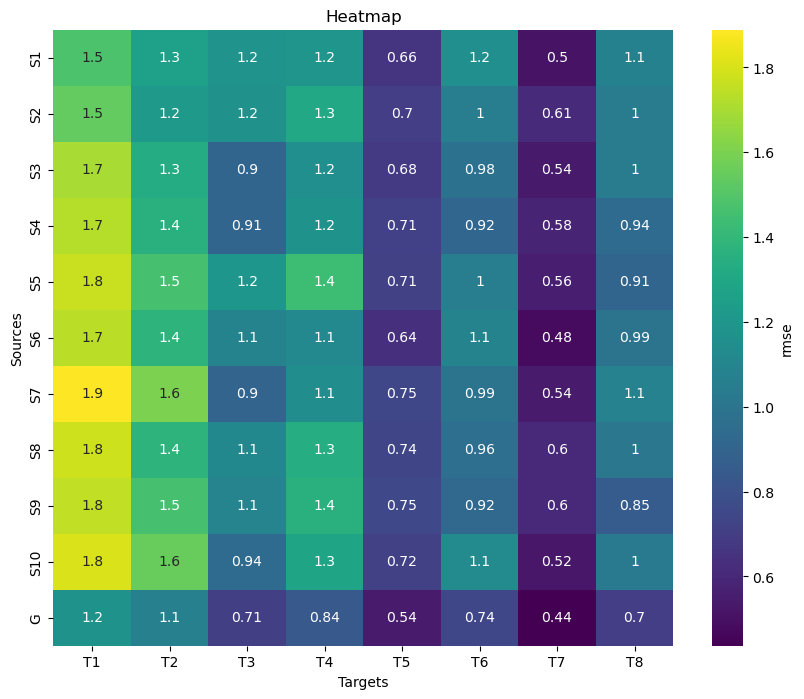

In [ ]:
metric = 'rmse' # specify the error metric, rmse, mae, and mase are available 

# Get sources and targets.
sources = list(error_finetuning.keys())
targets = list(next(iter(error_finetuning.values())).keys()) 

source_labels = [f"S{i+1}" for i in range(len(sources) - 1)] + ["G"]
target_labels = [f"T{i+1}" for i in range(len(targets))]

# Create MASE mastrix.
errors = np.zeros((len(sources), len(targets)))

# Insert values into the MASE matrix.
for i, source in enumerate(sources):
    if source =="gentl": continue
    for j, target in enumerate(targets):
        errors[i, j] = error_finetuning[source][target][metric]

# Handle the GenTL fientuning result seperately.
for j, target in enumerate(targets):
    errors[-1, j] = error_finetuning["gentl"][target][metric]

# Create heatmap based on the MASE matrix.
plt.figure(figsize=(10, 8))
sns.heatmap(errors, annot=True, xticklabels=target_labels, yticklabels=source_labels, cmap='viridis', cbar_kws={'label': metric})
plt.title("Heatmap")
plt.xlabel("Targets")
plt.ylabel("Sources")
plt.show()